In [25]:
import quandl
import pandas as pd
import numpy as np
import pandas_datareader as pdr 
#from datetime import datetime
import datetime
from __future__ import division
import math
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [6]:
#Set times, -1 = yearg ago from now
end = datetime.now()
print (end)

start = datetime(end.year -1, end.month, end.day)
print (start)

2018-06-07 22:12:03.122418
2017-06-07 00:00:00


In [7]:
#Import data from yahoo and assign it to IRBT
IRBT = pdr.DataReader('IRBT', 'yahoo', start, end)


In [8]:
IRBT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2017-06-07 to 2018-06-07
Data columns (total 6 columns):
Open         253 non-null float64
High         253 non-null float64
Low          253 non-null float64
Close        253 non-null float64
Adj Close    253 non-null float64
Volume       253 non-null int64
dtypes: float64(5), int64(1)
memory usage: 13.8 KB


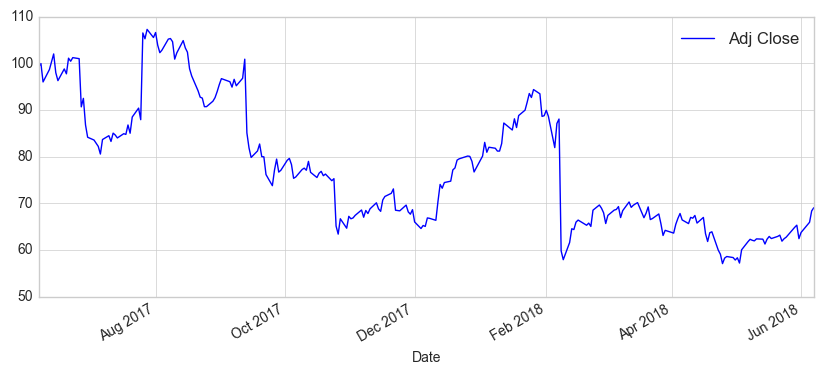

In [9]:
#View historical trend of the closing price Adj Close column
IRBT['Adj Close'].plot(legend=True, figsize=(10,4))

In [11]:
IRBT.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-06-07,96.860001,99.309998,96.080002,99.230003,99.230003,687500
2017-06-08,98.980003,100.480003,97.820000,99.930000,99.930000,633700
2017-06-09,100.419998,100.949997,93.129997,95.989998,95.989998,1135700
2017-06-12,95.989998,98.760002,91.510002,98.650002,98.650002,1133200
2017-06-13,99.430000,101.540001,98.500000,100.279999,100.279999,801200


In [12]:
IRBT.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-06-01,62.820000,64.349998,62.820000,63.730000,63.730000,619600
2018-06-04,64.099998,65.639999,64.099998,65.360001,65.360001,659500
2018-06-05,65.290001,66.080002,65.000000,65.919998,65.919998,510500
2018-06-06,66.220001,69.250000,65.949997,68.349998,68.349998,933200
2018-06-07,68.160004,69.290001,67.290001,69.040001,69.040001,625500


In [13]:
df = IRBT[['Open','High','Low','Close', 'Volume']]

df['HL_PCT'] = (df['High']-df['Close'])/ df['Close'] * 100.0

df['PCT_Change'] = (df['Close']-df['Open'])/ df['Open'] * 100.0


In [14]:
df = df [['Close','HL_PCT','PCT_Change','Volume']]

In [15]:
df.tail()

,Close,HL_PCT,PCT_Change,Volume
Date,,,,
2018-06-01,63.730000,0.972851,1.448583,619600
2018-06-04,65.360001,0.428394,1.965683,659500
2018-06-05,65.919998,0.242725,0.964921,510500
2018-06-06,68.349998,1.316755,3.216546,933200
2018-06-07,69.040001,0.362109,1.291075,625500


In [16]:
#Define a label -- Adj Price in the future
forecast_col = 'Close' 
df.fillna(-99999, inplace=True)
forecast_out = int(math.ceil(0.01*len(df)))

df['Label'] = df[forecast_col].shift(-forecast_out)
df.dropna(inplace=True)

df.head()

,Close,HL_PCT,PCT_Change,Volume,Label
Date,,,,,
2017-06-07,99.230003,0.080616,2.446833,687500,98.650002
2017-06-08,99.930000,0.550388,0.959787,633700,100.279999
2017-06-09,95.989998,5.167204,-4.411472,1135700,101.989998
2017-06-12,98.650002,0.111505,2.771126,1133200,97.970001
2017-06-13,100.279999,1.256484,0.854872,801200,96.269997


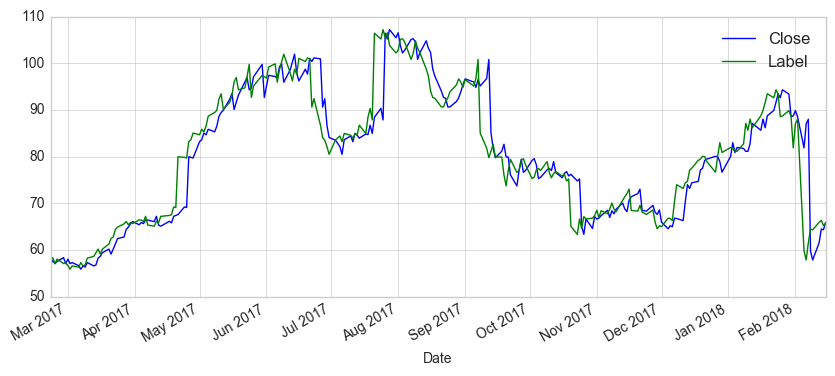

In [17]:
df[['Close','Label']].plot(subplots=False,legend=True, figsize=(10,4))

In [17]:
#Define features X and labels y

X = np.array(df.drop(['Label'],1))

y = np.array(df['Label'])

#Scale X
X = preprocessing.scale(X)
y = np.array(df['Label'])
print(len(X),len(y))

250 250


In [18]:
#Create training and testing sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)


In [19]:
#Define a classifier and test it .fit=train / .score=test
classf = LinearRegression()
classf.fit(X_train, y_train)
accuracy = classf.score(X_test, y_test)

print(forecast_out)
print(accuracy)

3
0.849147136972


In [20]:
#Using the Support Vector Machine algo

classf = svm.SVR()
classf.fit(X_train, y_train)
accuracy = classf.score(X_test, y_test)

print(forecast_out)
print(accuracy)

3
0.708794197356


In [21]:
#Forecasting into the future...
df['Label'] = df[forecast_col].shift(-forecast_out)
X = np.array(df.drop(['Label'],1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)
y = np.array(df['Label'])


#Create training and testing sets
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)

#Define a classifier and test it .fit=train / .score=test
classf = LinearRegression()
classf.fit(X_train, y_train)
accuracy = classf.score(X_test, y_test)

print(forecast_out)
print(accuracy)


3
0.925348943641


In [22]:
forecast_set = classf.predict(X_lately)
print (forecast_set, accuracy, forecast_out)

[ 62.91718632  63.80245711  65.64647982] 0.925348943641 3


In [23]:
df['Forecast']= np.nan

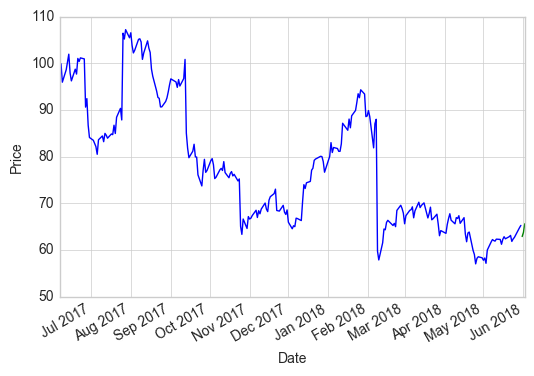

In [26]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+ [i]
   

df['Close'].plot()
df['Forecast'].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

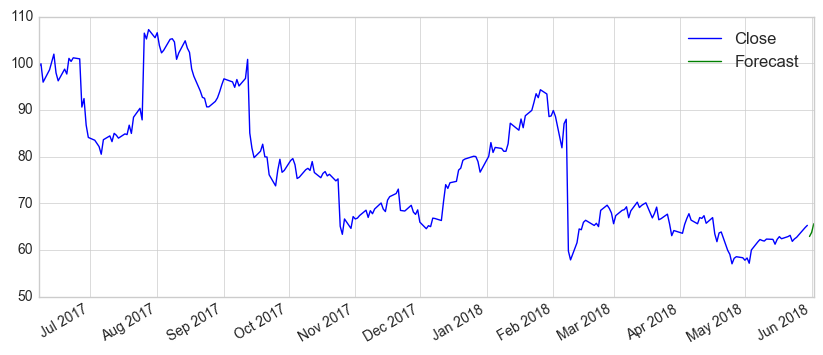

In [27]:
df[['Close','Forecast']].plot(subplots=False,legend=True, figsize=(10,4))

In [28]:
df

,Close,HL_PCT,PCT_Change,Volume,Label,Forecast
2017-06-07,99.230003,0.080616,2.446833,687500.0,98.650002,NaN
2017-06-08,99.930000,0.550388,0.959787,633700.0,100.279999,NaN
2017-06-09,95.989998,5.167204,-4.411472,1135700.0,101.989998,NaN
2017-06-12,98.650002,0.111505,2.771126,1133200.0,97.970001,NaN
2017-06-13,100.279999,1.256484,0.854872,801200.0,96.269997,NaN
2017-06-14,101.989998,2.568882,1.644411,1283400.0,98.779999,NaN
2017-06-15,97.970001,3.143822,-2.225545,1657400.0,97.730003,NaN
2017-06-16,96.269997,2.690354,-2.442241,1599000.0,101.080002,NaN
2017-06-19,98.779999,0.496050,1.877063,883400.0,100.430000,NaN
2017-06-20,97.730003,2.302261,-1.282825,604500.0,101.199997,NaN
